In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, mean_squared_error, r2_score, roc_auc_score, f1_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
import warnings
import xgboost as xgb
import lightgbm as lgb

warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [2]:
# --- Data Loading and Preprocessing ---
print("--- Data Loading and Preprocessing ---")
try:
    df = pd.read_csv('company_bankruptcy_dataset.csv')
except FileNotFoundError:
    print("Error: The file 'company_bankruptcy_dataset.csv' was not found. Please ensure it is in the correct directory.")
    exit()

# Rename columns for easier access
new_column_names = {
    'Current assets: All the assets of a company that are expected to be sold or used as a result of standard business operations over the next year\n': 'X1',
    'Cost of goods sold: The total amount a company paid as a cost directly related to the sale of products': 'X2',
    'Depreciation and amortization: Depreciation refers to the loss of value of a tangible fixed asset over time (such as property, machinery, buildings, and plant). Amortization refers to the loss of value of intangible assets over time.': 'X3',
    'EBITDA: Earnings before interest, taxes, depreciation, and amortization. A measure of a company’s overall financial performance alternative to net income': 'X4',
    'Inventory: The accounting of items and raw materials that a company either uses in production or sells': 'X5',
    'Net Income: The overall profitability of a company after all expenses and costs have been deducted from total revenue': 'X6',
    'Total Receivables: The balance of money due to a firm for goods or services delivered or used but not yet paid for by customers': 'X7',
    'Market Value: The price of an asset in a marketplace. In our dataset, it refers to the market capitalization since companies are publicly traded in the stock market': 'X8',
    'Net Sales: The sum of a company’s gross sales minus its returns, allowances, and discounts': 'X9',
    'Total Assets: All the assets, or items of value, a business owns': 'X10',
    'Total Long-term Debt: A company’s loans and other liabilities that will not become due within one year of the balance sheet date': 'X11',
    'EBIT: Earnings before interest and taxes': 'X12',
    'Gross Profit: The profit a company makes after deducting the costs associated with making and selling its products': 'X13',
    'Total Current Liabilities: A company’s debts or obligations that are due within one year': 'X14',
    'Retained Earnings: The accumulated net income of a corporation that is retained by the corporation at the end of each reporting period': 'X15',
    'Total Revenue: The total income generated by the sale of goods or services related to the company’s primary operations': 'X16',
    'Total Short-term Debt: Debts or obligations that must be paid within one year or one operating cycle, whichever is longer': 'X17',
    'Cash flow from operating activities: The amount of cash generated by the regular operating activities of a business within a specific time frame': 'X18'
}
df = df.rename(columns=new_column_names)

print("Initial data shape:", df.shape)
print(df.head())
print("\nData Info:")
df.info()

# Handle missing values by dropping them
df.dropna(inplace=True)
print("\nData shape after dropping missing values:", df.shape)

# Convert status_label to numerical
df['status_label'] = df['status_label'].map({'alive': 1, 'failed': 0})

# Separate features (X) and target (y)
X = df.drop(columns=['company_name', 'status_label'])
y = df['status_label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

--- Data Loading and Preprocessing ---
Initial data shape: (78682, 21)
  company_name status_label  year       X1       X2      X3      X4       X5  \
0          C_1        alive  1999  511.267  833.107  18.373  89.031  336.018   
1          C_1        alive  2000  485.856  713.811  18.577  64.367  320.590   
2          C_1        alive  2001  436.656  526.477  22.496  27.207  286.588   
3          C_1        alive  2002  396.412  496.747  27.172  30.745  259.954   
4          C_1        alive  2003  432.204  523.302  26.680  47.491  247.245   

       X6       X7  ...        X9      X10      X11     X12  \
0  35.163  128.348  ...  1024.333  740.998  180.447  70.658   
1  18.531  115.187  ...   874.255  701.854  179.987  45.790   
2 -58.939   77.528  ...   638.721  710.199  217.699   4.711   
3 -12.410   66.322  ...   606.337  686.621  164.658   3.573   
4   3.504  104.661  ...   651.958  709.292  248.666  20.811   

   Gross Profit: The profit a business makes after subtracting all th

In [3]:
# --- Feature Selection using Random Forest ---
print("\n--- Feature Selection using Random Forest ---")
rf_model_fs = RandomForestClassifier(random_state=42)
rf_model_fs.fit(X_train_scaled, y_train)
rf_feature_importances = pd.Series(rf_model_fs.feature_importances_, index=X.columns).abs()
selected_features_rf = rf_feature_importances.nlargest(10).index.tolist()
print("Selected features using Random Forest:", selected_features_rf)

# Use only selected features for all models
X_train_selected = X_train[selected_features_rf]
X_test_selected = X_test[selected_features_rf]

# Re-scale the selected features
X_train_final = scaler.fit_transform(X_train_selected)
X_test_final = scaler.transform(X_test_selected)


--- Feature Selection using Random Forest ---
Selected features using Random Forest: ['X8', 'Retained Earnings: The amount of profit a company has left over after paying all its direct costs, indirect costs, income taxes, and dividends to shareholders', 'X3', 'X1', 'Total Liabilities: The combined debts and obligations that the company owes to outside parties', 'X6', 'X7', 'Gross Profit: The profit a business makes after subtracting all the costs that are related to manufacturing and selling its products or services', 'X10', 'Total Current Liabilities: The sum of accounts payable, accrued liabilities, and taxes such as bonds payable at the end of the year, salaries, and commissions remaining']


In [4]:
# --- 3. Model Training and Evaluation ---
print("\n--- Model Training and Evaluation ---")

# Dictionary to store model results
model_metrics = {
    'Model': [],
    'Accuracy': [],
    'ROC AUC': [],
    'F1 Score': [],
    'Cross-Validation Score': []
}

def evaluate_model(model_name, model, X_train, y_train, X_test, y_test):
    print(f"\n--- {model_name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    print("F1 Score: {:.2f}".format(f1))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    try:
        y_scores = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_scores)
        print(f"ROC AUC: {roc_auc:.2f}")
    except AttributeError:
        # Handle models that don't have predict_proba (like some SVMs)
        print("ROC AUC: N/A (predict_proba not available)")
        roc_auc = None
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    avg_cv_score = cv_scores.mean()
    print(f"Average 5-Fold Cross-Validation Score: {avg_cv_score:.2f}")
    
    # Store metrics
    model_metrics['Model'].append(model_name)
    model_metrics['Accuracy'].append(accuracy)
    model_metrics['ROC AUC'].append(roc_auc)
    model_metrics['F1 Score'].append(f1)
    model_metrics['Cross-Validation Score'].append(avg_cv_score)
    
    return accuracy, f1, roc_auc, avg_cv_score

# List of models to evaluate
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(kernel='linear', probability=True, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naïve Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42)
}

for name, model in models.items():
    evaluate_model(name, model, X_train_final, y_train, X_test_final, y_test)


--- Model Training and Evaluation ---

--- Logistic Regression ---
Accuracy: 93.21%
F1 Score: 0.96

Confusion Matrix:
[[    5  1063]
 [    6 14663]]

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.00      0.01      1068
           1       0.93      1.00      0.96     14669

    accuracy                           0.93     15737
   macro avg       0.69      0.50      0.49     15737
weighted avg       0.90      0.93      0.90     15737

ROC AUC: 0.65
Average 5-Fold Cross-Validation Score: 0.93

--- Random Forest ---
Accuracy: 93.50%
F1 Score: 0.97

Confusion Matrix:
[[   54  1014]
 [    9 14660]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.05      0.10      1068
           1       0.94      1.00      0.97     14669

    accuracy                           0.93     15737
   macro avg       0.90      0.52      0.53     15737
weighted avg       0.93      0.93      0

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ROC AUC: 0.52
Average 5-Fold Cross-Validation Score: 0.93

--- Decision Tree ---
Accuracy: 89.22%
F1 Score: 0.94

Confusion Matrix:
[[  247   821]
 [  876 13793]]

Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.23      0.23      1068
           1       0.94      0.94      0.94     14669

    accuracy                           0.89     15737
   macro avg       0.58      0.59      0.58     15737
weighted avg       0.89      0.89      0.89     15737

ROC AUC: 0.59
Average 5-Fold Cross-Validation Score: 0.89

--- K-Nearest Neighbors ---
Accuracy: 93.46%
F1 Score: 0.97

Confusion Matrix:
[[  180   888]
 [  141 14528]]

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.17      0.26      1068
           1       0.94      0.99      0.97     14669

    accuracy                           0.93     15737
   macro avg       0.75      0.58      0.61     15737
weighted avg       0.


--- Model Comparison ---
                 Model  Accuracy   ROC AUC  F1 Score  Cross-Validation Score
0  Logistic Regression  0.932071  0.646938  0.964830                0.933768
1        Random Forest  0.934994  0.819678  0.966285                0.936707
2                  SVM  0.932134  0.517666  0.964875                0.934038
3        Decision Tree  0.892165  0.585778  0.942048                0.891763
4  K-Nearest Neighbors  0.934613  0.755676  0.965797                0.936913
5          Naïve Bayes  0.145708  0.550507  0.159540                0.144491
6    Gradient Boosting  0.932262  0.722408  0.964918                0.934244
7              XGBoost  0.934231  0.781077  0.965827                0.935483
8             LightGBM  0.933532  0.774911  0.965549                0.935547

--- Visualizing Performance ---


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26272\3252927489.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary_df.index, y='Accuracy', data=summary_df, palette='viridis')


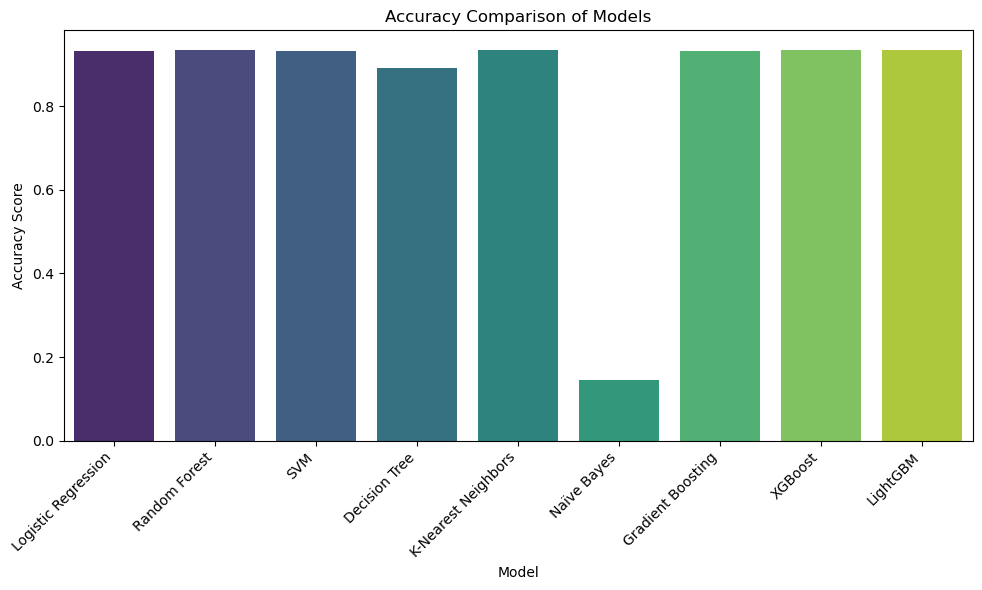

C:\Users\ASUS\AppData\Local\Temp\ipykernel_26272\3252927489.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary_df.index, y='ROC AUC', data=summary_df.dropna(), palette='plasma')


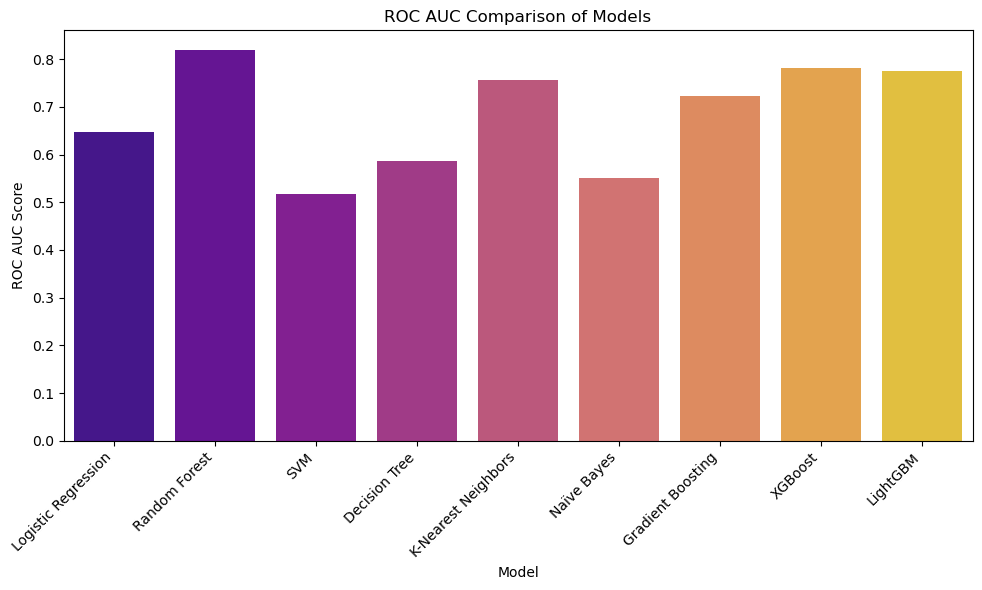

C:\Users\ASUS\AppData\Local\Temp\ipykernel_26272\3252927489.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary_df.index, y='F1 Score', data=summary_df, palette='coolwarm')


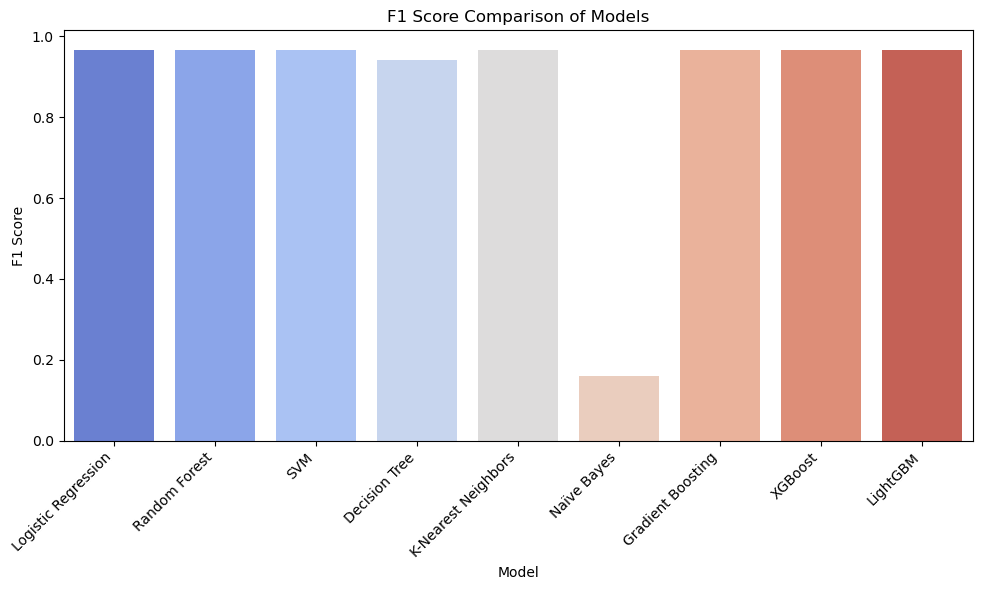

In [5]:
# --- 4. Model Comparison ---
print("\n--- Model Comparison ---")
summary_df = pd.DataFrame(model_metrics)
print(summary_df)

# --- 5. Visualization of Performance Metrics ---
print("\n--- Visualizing Performance ---")
summary_df.set_index('Model', inplace=True)

# Plot Accuracy Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=summary_df.index, y='Accuracy', data=summary_df, palette='viridis')
plt.title('Accuracy Comparison of Models')
plt.ylabel('Accuracy Score')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('accuracy_comparison.png')
plt.show()

# Plot ROC AUC Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=summary_df.index, y='ROC AUC', data=summary_df.dropna(), palette='plasma')
plt.title('ROC AUC Comparison of Models')
plt.ylabel('ROC AUC Score')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('roc_auc_comparison.png')
plt.show()

# Plot F1 Score Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=summary_df.index, y='F1 Score', data=summary_df, palette='coolwarm')
plt.title('F1 Score Comparison of Models')
plt.ylabel('F1 Score')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('f1_score_comparison.png')
plt.show()